<figure>
    <img src="LogoE.png" style="width:15%" align="right">
</figure>
<h1>Detector de rocas automático con deep learning: parte 2</h1>

<p>Anteriormente se describió el proceso para relaizar un detector en tiempo real, en este documento se describirá el proceso posterior a la generación del clasificador y su implementación con ventanas deslizantes.</p>
<p>A continuación se cargará el mejor modelo de redes neuronales, i.e. el que tiene mejor performance.</p>

In [2]:
from keras.models import load_model

resnetrock = load_model('rocas_2_3.h5') 
resnetrock.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 2565      
Total params: 24,902,021
Trainable params: 1,314,309
Non-trainable params: 23,587,712
________________________________________________________

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def draw_boxes(img, boxes, width_line = 3, multicolor=True, colorbox="bisque"):
    draw_img = np.copy(img)
    color = [(0,0,255),(0,255,0),(255,0,0),(0,0,0),(255,255,0),(255,0,255),(0,255,255),(255,255,255)]
    if colorbox != "bisque":
        for box in boxes:
            cv2.rectangle(draw_img,box[0],box[1],colorbox, width_line)
    else:
        if multicolor==True: n = 8
        else: n = 1
        k = 0
        for box in boxes:
            cv2.rectangle(draw_img,box[0],box[1],color[k%n], width_line)
            k += 1
    return cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

# Generacion de cajas para buscar el objeto
def sliding_window(x0, xf, y0s, widths, overlap):
    #print("ventana movil")
    boxes = []
    #print("entra al for")
    for width,y0 in zip(widths,y0s):
        #print("width {}, y0: {}".format(width,y0))
        xdelta = int((1-overlap)*width)
        #print("xdelta: {}".format(xdelta))
        #print("range: {}".format(range(x0,xf,xdelta)))
        for x in range(x0,xf,xdelta):
            #print("x:{}".format(x))
            box = ((x,y0),(x+width,y0+width))
            #print("box:{}\n".format(box))
            boxes.append(box)
    return boxes

In [3]:
imgname = 'descarga3.jpg'  
imgCV = cv2.imread(imgname)     #Imagen para visualizar
imgCV.shape

(1200, 1600, 3)

Primeras 5 cajas de la cuadricula:  [((0, 0), (300, 300)), ((59, 0), (359, 300)), ((118, 0), (418, 300)), ((177, 0), (477, 300)), ((236, 0), (536, 300))]


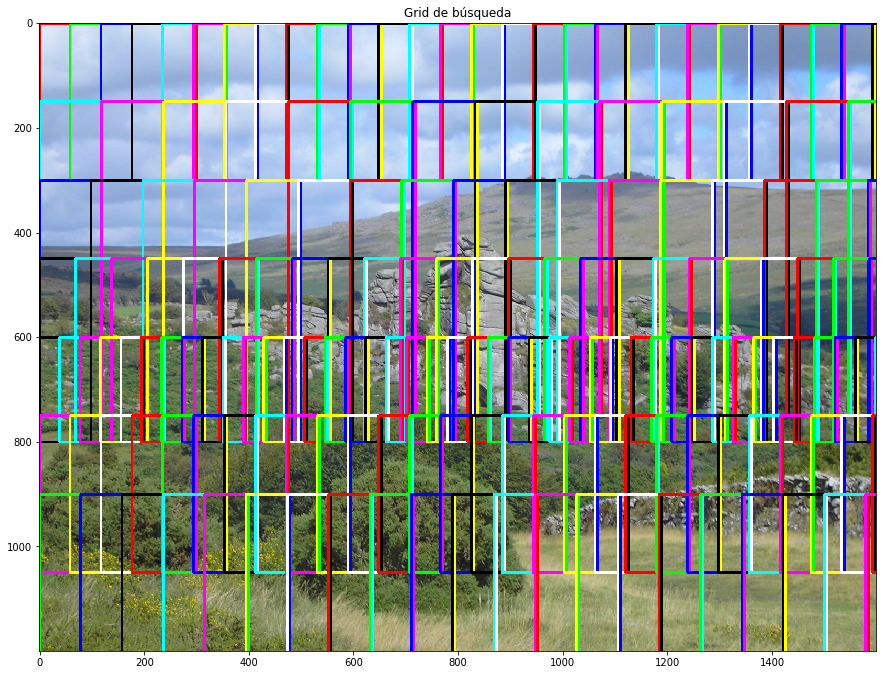

In [4]:
# Para verificar la función SW
overlap = 0.80
yi = 100
y0s = [0,150,300,450,600,750,900]
widths = [300,600,500,350,200,300,400]
boxes_for_search = sliding_window(0, imgCV.shape[1], y0s, widths, overlap)
print('Primeras 5 cajas de la cuadricula: ', boxes_for_search[0:5])

img_gridsearch = draw_boxes(imgCV, boxes_for_search)
plt.figure(figsize=(15,15))
plt.imshow(img_gridsearch)
plt.title('Grid de búsqueda')
plt.savefig('grid_busqueda.png')
plt.show()

20


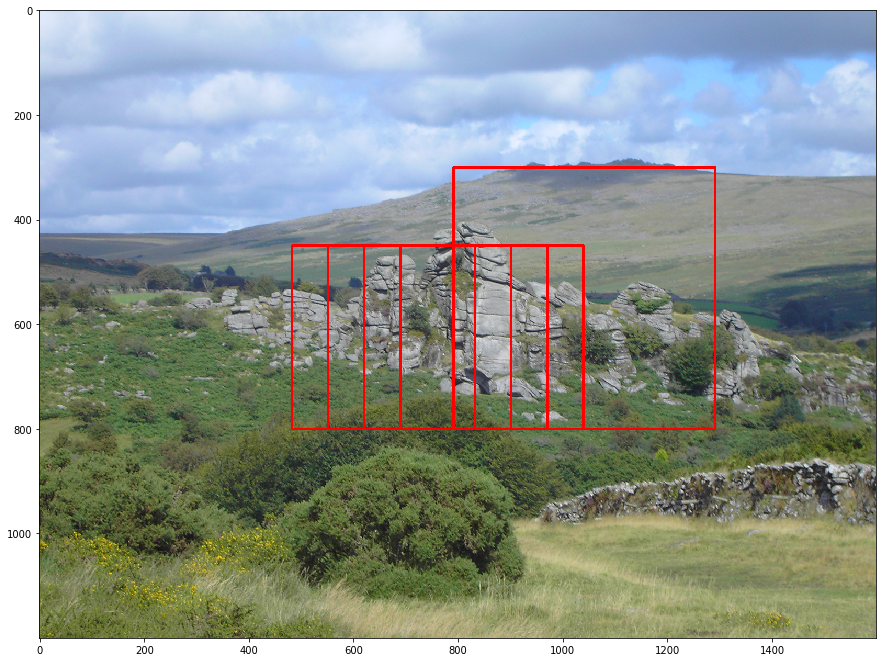

In [5]:
from keras.preprocessing import image
from skimage.transform import resize

# Detectar cuales cajas contienen probablemente un coche
def findrocks(img, swboxes, threshold=0.8):
    detected_sand = []
    detected_basalt = []
    detected_conglo = []
    detected_other = []
    detected_shale = []
    for box in swboxes:
        swimg = resize(img[box[0][1]:box[1][1],box[0][0]:box[1][0]], (224,224,3))
        x = np.expand_dims(swimg.astype('float32'), axis=0)
        x /= 255.0
        clase = resnetrock.predict(x)
        #print(clase)
        #print(np.max(clase[0]))
        if clase[0][0] == np.max(clase[0]) and clase[0][0] > threshold: 
            #print("arenisca")
            detected_sand.append(box)
        if clase[0][1] == np.max(clase[0]) and clase[0][1] > threshold: 
            #print("basalto")
            detected_basalt.append(box)
        if clase[0][2] == np.max(clase[0]) and clase[0][2] > threshold: 
            #print("conglomerado")
            detected_conglo.append(box)
        if clase[0][4] == np.max(clase[0]) and clase[0][4] > threshold: 
            #print("shale")
            detected_shale.append(box)
    return detected_sand, detected_basalt, detected_conglo, detected_shale

# Para verificar la función findcars
swboxes = boxes_for_search[50:70]
print(len(swboxes))
imgname = 'descarga3.jpg'  #Imagen para detectar
img = image.load_img(imgname)
img = image.img_to_array(img)
detected_sand, detected_basalt, detected_conglo, detected_shale = findrocks(img, swboxes, threshold=0.5)  #Probar varios valores de umbral
img_detections = draw_boxes(imgCV, detected_basalt, multicolor=False)
plt.figure(figsize=(15,15))
plt.imshow(img_detections)
plt.show()

Mapa de calor generado
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 1 1]
 [1 2 1 1 0 0 1 0 1 1]
 [1 2 1 1 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]

Mapa de calor cortado
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]

Zonas etiquetadas (labels)
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]

Zonas etiquetadas (labels)
[((1, 4), (1, 5))]



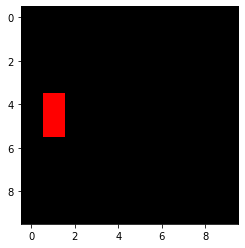

In [6]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
         # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1],box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    cut_heatmap = np.copy(heatmap)
    cut_heatmap[heatmap <= threshold] = 0
    return np.clip(cut_heatmap, 0, 255).astype(np.uint8)

def enclosed_labels(labels):
    final_detections = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        wy_box = box[0][1]-box[1][1]
        wx_box = box[0][0]-box[1][0]
        if True: # ejemplo: abs(wx_box) > 0.5*abs(wy_box), ó bien, abs(wx_box) > 5 and abs(wy_box) > 5
            final_detections.append(box)
    return final_detections

from scipy.ndimage.measurements import label

# Verificar las funciones anteriores con un mapa de calor 10x10
heatmap = np.zeros((10,10))
detected_boxes = [((0, 2), (2, 6)), 
                  ((8,1), (10,5)), 
                  ((1,4), (4,9)),
                  ((6,4), (7,5))]
heatmap = add_heat(heatmap,detected_boxes)
print('Mapa de calor generado')
print(heatmap.astype(int))
print()
heatmap = apply_threshold(heatmap,1)  
print('Mapa de calor cortado')
print(heatmap)
print()
labels = label(heatmap)
print('Zonas etiquetadas (labels)')
print(labels[0])
print()
final_detections = enclosed_labels(labels)
print('Zonas etiquetadas (labels)')
print(final_detections)
print()

img = draw_boxes(np.zeros((10,10,3)).astype('uint8'), 
                 final_detections, 
                 width_line=1, multicolor=True)
plt.imshow(img)
plt.show()

Número de cajas de areniscas detectadas = 4
Número de cajas de basaltos detectadas = 26
Número de cajas de conglomerados detectadas = 2
Número de cajas de lutitas detectadas = 5


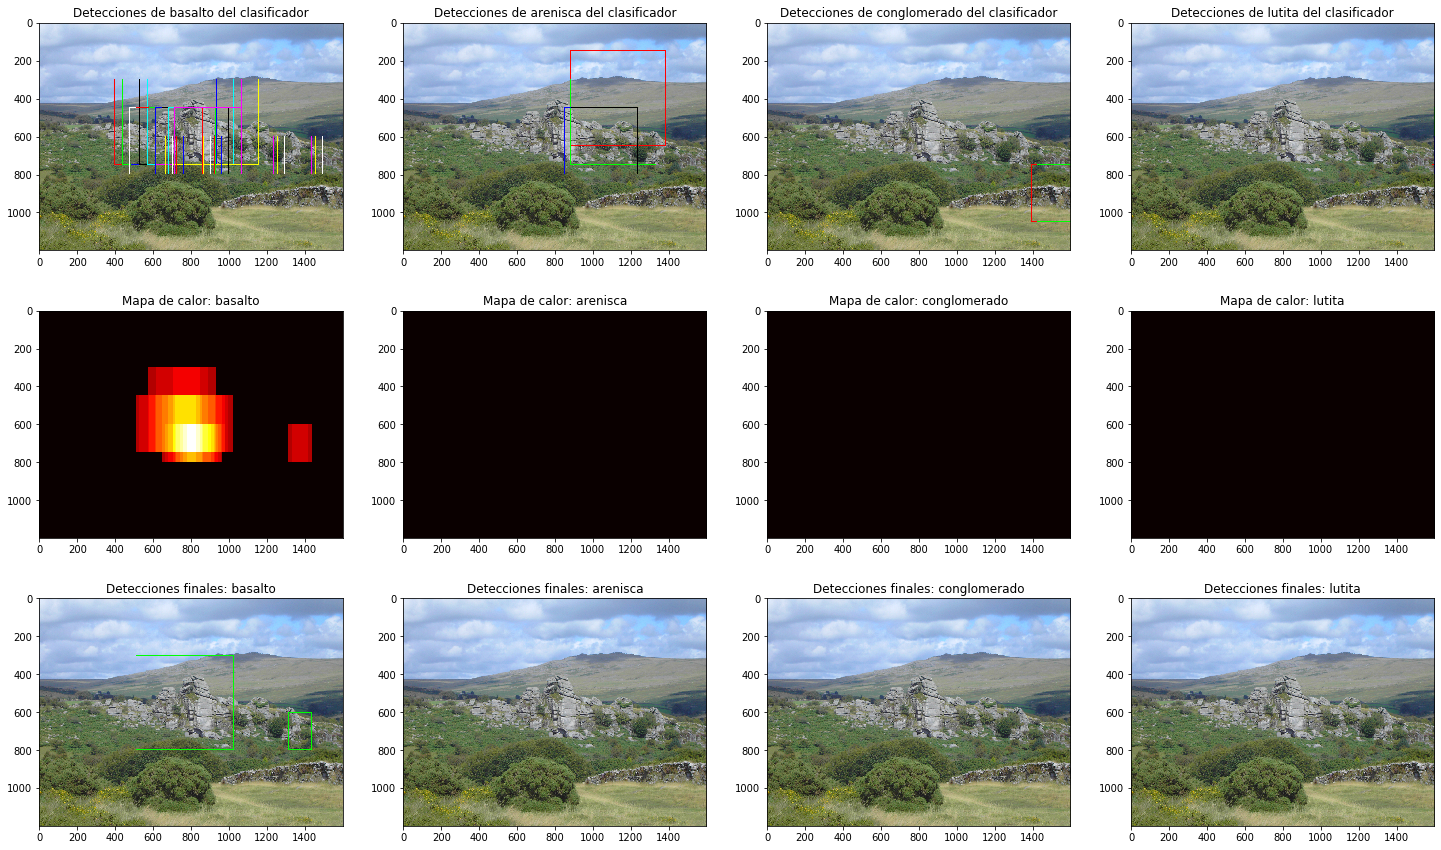

In [26]:
# Hiper-parametros
overlap = 0.9
y0s = [0,150,300,450,600,750,900]
widths = [300,500,450,350,200,300,400]
heat_threshold = 4
threshold=0.85
imgname = 'descarga3.jpg'

# Generar las cajas donde se buscara los coches
boxes_for_search = sliding_window(0, 1600, y0s, widths, overlap)

# Realizar las detecciones por el clasificador
img = image.load_img(imgname)
img = image.img_to_array(img)
detected_sand, detected_basalt, detected_conglo, detected_shale = findrocks(img, boxes_for_search, threshold=threshold) 
print('Número de cajas de areniscas detectadas =', len(detected_sand))
print('Número de cajas de basaltos detectadas =', len(detected_basalt))
print('Número de cajas de conglomerados detectadas =', len(detected_conglo))
print('Número de cajas de lutitas detectadas =', len(detected_shale))

# Dibujar detecciones iniciales
imgCV = cv2.imread(imgname) 
img_wdetections = draw_boxes(imgCV, detected_basalt, width_line=2, multicolor=True)#, colorbox=(0,255,0))
imgCV = cv2.imread(imgname)
sand_wdetections = draw_boxes(imgCV, detected_sand, width_line=2, multicolor=True)#, colorbox=(255,0,0))
imgCV = cv2.imread(imgname)
cong_wdetections = draw_boxes(imgCV, detected_conglo, width_line=2, multicolor=True)#, colorbox=(0,0,0))
imgCV = cv2.imread(imgname)
shle_wdetections = draw_boxes(imgCV, detected_shale, width_line=2, multicolor=True)#, colorbox=(255,255,0))

# Calcular mapa de calor 
heat_sand = np.zeros_like(img[:,:,0]).astype(np.float)
heat_sand = add_heat(heat_sand, detected_sand)
heat_sand = apply_threshold(heat_sand,heat_threshold)
heat_bas = np.zeros_like(img[:,:,0]).astype(np.float)
heat_bas = add_heat(heat_bas, detected_basalt)
heat_bas = apply_threshold(heat_bas,heat_threshold)
heat_con = np.zeros_like(img[:,:,0]).astype(np.float)
heat_con = add_heat(heat_con, detected_conglo)
heat_con = apply_threshold(heat_con,heat_threshold)
heat_shl = np.zeros_like(img[:,:,0]).astype(np.float)
heat_shl = add_heat(heat_shl, detected_shale)
heat_shl = apply_threshold(heat_shl,heat_threshold)

# Calcular detecciones finales
labels_bas = label(heat_bas)
final_detections_bas = enclosed_labels(labels_bas)
img_wlabels_bas = draw_boxes(np.copy(imgCV), final_detections_bas, multicolor=False, colorbox=(0,255,0))
labels_sand = label(heat_sand)
final_detections_sand = enclosed_labels(labels_sand)
img_wlabels_sand = draw_boxes(np.copy(imgCV), final_detections_sand, multicolor=False)
labels_con = label(heat_con)
final_detections_con = enclosed_labels(labels_con)
img_wlabels_con = draw_boxes(np.copy(imgCV), final_detections_con, multicolor=False, colorbox=(255,0,0))
labels_shl = label(heat_shl)
final_detections_shl = enclosed_labels(labels_shl)
img_wlabels_shl = draw_boxes(np.copy(imgCV), final_detections_shl, multicolor=False, colorbox=(255,255,0))

# Visualización
plt.figure(figsize=(25,15))
plt.subplot(3,4,1)
plt.imshow(img_wdetections)
plt.title('Detecciones de basalto del clasificador')
plt.subplot(3,4,2)
plt.imshow(sand_wdetections)
plt.title('Detecciones de arenisca del clasificador')
plt.subplot(3,4,3)
plt.imshow(cong_wdetections)
plt.title('Detecciones de conglomerado del clasificador')
plt.subplot(3,4,4)
plt.imshow(shle_wdetections)
plt.title('Detecciones de lutita del clasificador')

plt.subplot(3,4,5) 
plt.imshow(heat_bas, cmap='hot')
plt.title('Mapa de calor: basalto')
plt.subplot(3,4,6) 
plt.imshow(heat_sand, cmap='hot')
plt.title('Mapa de calor: arenisca')
plt.subplot(3,4,7) 
plt.imshow(heat_con, cmap='hot')
plt.title('Mapa de calor: conglomerado')
plt.subplot(3,4,8) 
plt.imshow(heat_shl, cmap='hot')
plt.title('Mapa de calor: lutita')

plt.subplot(3,4,9)
plt.imshow(img_wlabels_bas)
plt.title('Detecciones finales: basalto')
plt.subplot(3,4,10)
plt.imshow(img_wlabels_sand)
plt.title('Detecciones finales: arenisca')
plt.subplot(3,4,11)
plt.imshow(img_wlabels_con)
plt.title('Detecciones finales: conglomerado')
plt.subplot(3,4,12)
plt.imshow(img_wlabels_shl)
plt.title('Detecciones finales: lutita')

plt.savefig('clasificador_SW.png')
plt.show()

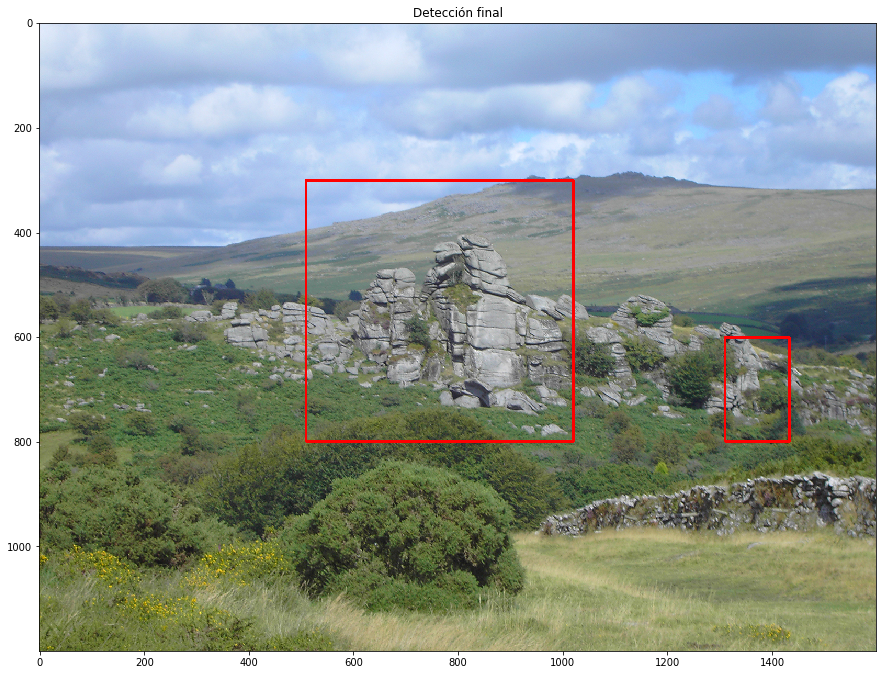

In [27]:
def draw_boxes_rocks(img, boxes_sand, boxes_bas, boxes_con, boxes_shl, width_line = 3):
    draw_img = np.copy(img)
    color_sand = (0,0,255)
    color_bas =  (0,255,0)#(255,255,255),(0,0,0),,(255,0,255),(0,255,255)
    color_con = (255,0,0)
    color_shl = (255,255,0)
    for box in boxes_sand:
        cv2.rectangle(draw_img,box[0],box[1],color_sand, width_line)
    for box in boxes_bas:
        cv2.rectangle(draw_img,box[0],box[1],color_bas, width_line)
    for box in boxes_con:
        cv2.rectangle(draw_img,box[0],box[1],color_con, width_line)
    for box in boxes_shl:
        cv2.rectangle(draw_img,box[0],box[1],color_shl, width_line)
    return cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
img_labels = draw_boxes_rocks(np.copy(imgCV), final_detections_bas, final_detections_sand, final_detections_con, final_detections_shl)
plt.figure(figsize=(15,15))
plt.imshow(img_labels)
plt.title('Detección final')
plt.savefig('deteccion_final.png')
plt.show()

In [ ]:
# Hiper-parametros
overlap = 0.9
y0s = [0,150,300,450,600,750,900]
widths = [300,500,450,350,200,300,400]
heat_threshold = 4
threshold=0.85
imgname = 'descarga3.jpg'

# Generar las cajas donde se buscara los coches
boxes_for_search = sliding_window(0, 1600, y0s, widths, overlap)

# Realizar las detecciones por el clasificador
img = image.load_img(imgname)
img = image.img_to_array(img)
detected_sand, detected_basalt, detected_conglo, detected_shale = findrocks(img, boxes_for_search, threshold=threshold) 

# Calcular mapa de calor 
heat_sand = np.zeros_like(img[:,:,0]).astype(np.float)
heat_sand = add_heat(heat_sand, detected_sand)
heat_sand = apply_threshold(heat_sand,heat_threshold)
heat_bas = np.zeros_like(img[:,:,0]).astype(np.float)
heat_bas = add_heat(heat_bas, detected_basalt)
heat_bas = apply_threshold(heat_bas,heat_threshold)
heat_con = np.zeros_like(img[:,:,0]).astype(np.float)
heat_con = add_heat(heat_con, detected_conglo)
heat_con = apply_threshold(heat_con,heat_threshold)
heat_shl = np.zeros_like(img[:,:,0]).astype(np.float)
heat_shl = add_heat(heat_shl, detected_shale)
heat_shl = apply_threshold(heat_shl,heat_threshold)

# Calcular detecciones finales
labels_bas = label(heat_bas)
final_detections_bas = enclosed_labels(labels_bas)
labels_sand = label(heat_sand)
final_detections_sand = enclosed_labels(labels_sand)
labels_con = label(heat_con)
final_detections_con = enclosed_labels(labels_con)
labels_shl = label(heat_shl)
final_detections_shl = enclosed_labels(labels_shl)

img_labels = draw_boxes_rocks(np.copy(imgCV), final_detections_bas, final_detections_sand, final_detections_con, final_detections_shl)
plt.figure(figsize=(15,15))
plt.imshow(img_labels)
plt.title('Detección final')
plt.savefig('deteccion_final.png')
plt.show()